# Import

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go

# DỮ LIỆU

## GIÁ CÀ PHÊ

In [ ]:
df_coffee = pd.read_csv('https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/CaPhe/gia_cafe.csv', encoding='ISO-8859-1')
df_coffee.tail()

,date,price
6353,5/28/2024,116700.0
6354,5/29/2024,120700.0
6355,5/30/2024,122700.0
6356,5/31/2024,123500.0
6357,6/1/2024,120000.0


In [ ]:
df_coffee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6358 entries, 0 to 6357
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6358 non-null   object 
 1   price   6358 non-null   float64
dtypes: float64(1), object(1)
memory usage: 99.5+ KB


In [ ]:
df_coffee['date'] = pd.to_datetime(df_coffee['date'])
df_coffee.set_index('date', inplace=True)

### Điền dữ liệu ngày thiếu

In [ ]:
idx = pd.date_range(df_coffee.index.min(), df_coffee.index.max())
df_coffee = df_coffee.reindex(idx)
df_coffee.fillna(method='ffill', inplace=True)
df_coffee.tail()

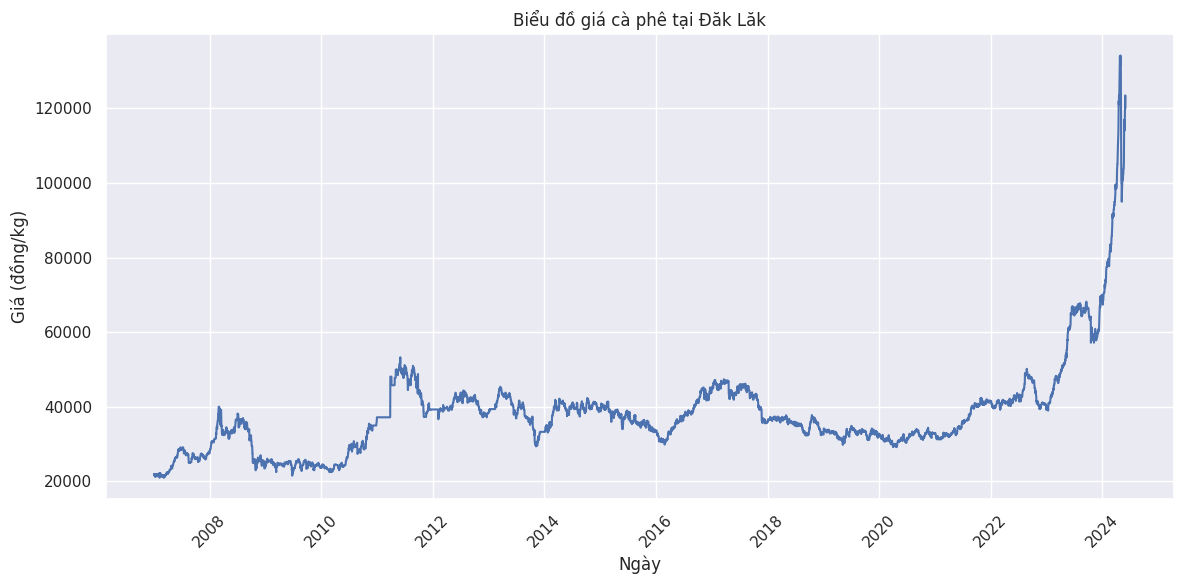

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_coffee, x=df_coffee.index, y='price')
plt.title('Biểu đồ giá cà phê tại Đăk Lăk')
plt.xlabel('Ngày')
plt.ylabel('Giá (đồng/kg)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## XUẤT KHẨU VÀ PHÊ

In [ ]:
df_coffee_export = pd.read_csv('https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/CaPhe/gia_xuat_khau_cafe.csv', encoding='ISO-8859-1')
df_coffee_export.head()

,date,Luong (nghin tan),Kim ngach (trieu USD),Trieu USD/ Nghin tan
0,1/1/2009,151.13,232.00,1.535102
1,2/1/2009,154.40,236.62,1.532513
2,3/1/2009,137.02,199.81,1.458254
3,4/1/2009,123.77,180.16,1.455603
4,5/1/2009,93.09,134.10,1.440541


In [ ]:
df_coffee_export['date'] = pd.to_datetime(df_coffee_export['date'])
df_coffee_export.set_index('date', inplace=True)

### Xử lý outlier

<Axes: >

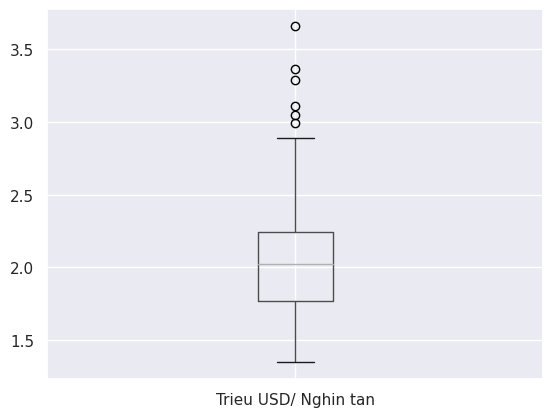

In [ ]:
df_coffee_export[['Trieu USD/ Nghin tan']].boxplot()

In [ ]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df_coffee_export['Trieu USD/ Nghin tan'].quantile(0.25)
Q3 = df_coffee_export['Trieu USD/ Nghin tan'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [ ]:
# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df_coffee_export[(df_coffee_export['Trieu USD/ Nghin tan'] < lower_bound) | (df_coffee_export['Trieu USD/ Nghin tan'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

Số lượng outlier: 6


In [ ]:
# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df_coffee_export.at[df_coffee_export.index[0], 'Trieu USD/ Nghin tan'] = min(max(df_coffee_export.iloc[0]['Trieu USD/ Nghin tan'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df_coffee_export.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df_coffee_export.index[previous_date_index]
        previous_value = df_coffee_export.loc[previous_date, 'Trieu USD/ Nghin tan']
        df_coffee_export.at[index, 'Trieu USD/ Nghin tan'] = previous_value

<Axes: >

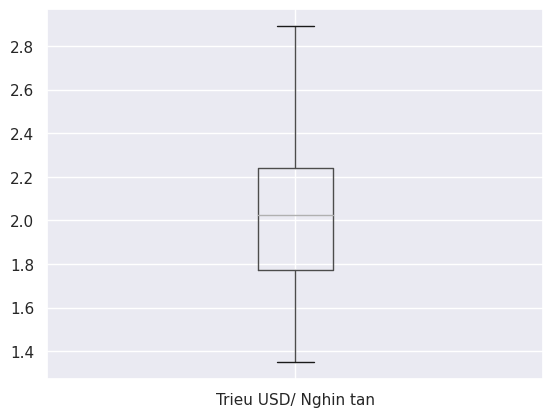

In [ ]:
df_coffee_export[['Trieu USD/ Nghin tan']].boxplot()

### Fill dữ liệu ngày bị thiếu

In [ ]:
idx = pd.date_range(df_coffee_export.index.min(), df_coffee_export.index.max())
df_coffee_export = df_coffee_export.reindex(idx)

In [ ]:
df_coffee_export.fillna(method='ffill', inplace=True)
df_coffee_export.head()

,Luong (nghin tan),Kim ngach (trieu USD),Trieu USD/ Nghin tan
2009-01-01,151.13,232.0,1.535102
2009-01-02,151.13,232.0,1.535102
2009-01-03,151.13,232.0,1.535102
2009-01-04,151.13,232.0,1.535102
2009-01-05,151.13,232.0,1.535102


### Merge dữ liệu xuất khẩu vào giá cà phê

In [ ]:
start_date = df_coffee_export.index.min()
df_coffee_filtered = df_coffee.loc[start_date:]

df_merged_coffee_export = pd.merge(df_coffee_filtered, df_coffee_export[['Trieu USD/ Nghin tan']], left_index=True, right_index=True, how='left')
df_merged_coffee_export['Trieu USD/ Nghin tan'] = df_merged_coffee_export['Trieu USD/ Nghin tan'].ffill()

print(df_merged_coffee_export.tail())

               price  Trieu USD/ Nghin tan
date                                      
2024-05-28  116700.0              2.892161
2024-05-29  120700.0              2.892161
2024-05-30  122700.0              2.892161
2024-05-31  123500.0              2.892161
2024-06-01  120000.0              2.892161


In [ ]:
correlation_matrix = df_merged_coffee_export.corr()

plt.figure(figsize=(6, 6), dpi=75)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=.5, cmap='coolwarm', center=0)
plt.title('Biểu đồ nhiệt ma trận tương quan')
plt.show()

### Làm mịn dữ liệu

In [ ]:
df_merged_coffee_export = df_merged_coffee_export.rolling(window=60, min_periods=1).mean()

# Mô hình dự đoán

## Giá cà phê kết hợp giá xuất khẩu

### Xây dựng mô hình

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
df_coffee_export_predictions = df_merged_coffee_export.copy()

scaler_price = MinMaxScaler(feature_range=(0, 1))
scaled_price = scaler_price.fit_transform(df_coffee_export_predictions[['price']])

scaler_export = MinMaxScaler(feature_range=(0, 1))
scaled_export = scaler_export.fit_transform(df_coffee_export_predictions[['Trieu USD/ Nghin tan']])

scaled_data = np.concatenate((scaled_price, scaled_export), axis=1)

In [ ]:
seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

In [ ]:
X.shape, y.shape

((5598, 30, 2), (5598,))

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Kích thước tập huấn luyện:", X_train.shape, y_train.shape)
print("Kích thước tập kiểm tra:", X_test.shape, y_test.shape)

Kích thước tập huấn luyện: (4478, 30, 2) (4478,)
Kích thước tập kiểm tra: (1120, 30, 2) (1120,)


In [ ]:
model_coffee_export = Sequential()
model_coffee_export.add(GRU(units=128, return_sequences=True, input_shape=(seq_length, 2)))
model_coffee_export.add(Dropout(0.2))
model_coffee_export.add(GRU(units=64))
model_coffee_export.add(Dropout(0.2))
model_coffee_export.add(Dense(units=1))

In [ ]:
model_coffee_export.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [ ]:
model_coffee_export.fit(X_train, y_train, epochs=50, batch_size=64, callbacks=[early_stopping])

Epoch 1/50
70/70 [==============================] - 10s 74ms/step - loss: 0.0016
Epoch 2/50
70/70 [==============================] - 7s 99ms/step - loss: 3.3540e-04
Epoch 3/50
70/70 [==============================] - 5s 74ms/step - loss: 2.1273e-04
Epoch 4/50
70/70 [==============================] - 7s 101ms/step - loss: 2.0387e-04
Epoch 5/50
70/70 [==============================] - 5s 74ms/step - loss: 1.6724e-04
Epoch 6/50
70/70 [==============================] - 6s 89ms/step - loss: 1.5043e-04
Epoch 7/50
70/70 [==============================] - 6s 83ms/step - loss: 1.2498e-04
Epoch 8/50
70/70 [==============================] - 5s 74ms/step - loss: 1.2964e-04
Epoch 9/50
70/70 [==============================] - 7s 101ms/step - loss: 1.1565e-04
Epoch 10/50
70/70 [==============================] - 5s 74ms/step - loss: 1.1049e-04
Epoch 11/50
70/70 [==============================] - 7s 100ms/step - loss: 9.7401e-05
Epoch 12/50
70/70 [==============================] - 5s 74ms/step - loss: 

### Dự đoán trên tập train

In [ ]:
train_predictions = model_coffee_export.predict(X_train)

140/140 [==============================] - 3s 13ms/step


In [ ]:
train_predictions = scaler_price.inverse_transform(train_predictions)
y_train = scaler_price.inverse_transform(y_train.reshape(-1, 1))

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mape = calculate_mape(y_train, train_predictions)

print(f'Training RMSE: {train_rmse:.2f}')
print(f'Training MAPE: {train_mape:.2f}%')

Training RMSE: 265.31
Training MAPE: 0.71%


In [ ]:
dates = df_merged_coffee_export.index.tolist()

fig = go.Figure()

fig.add_trace(go.Scatter(x=dates[:len(y_train)], y=y_train.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=dates[:len(train_predictions)], y=train_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá cà phê trên tập huấn luyện (mô hình GRU, dữ liệu giá cà phê và xuất khẩu)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mape = calculate_mape(y_train, train_predictions)

print(f'Training RMSE: {train_rmse:.2f}')
print(f'Training MAPE: {train_mape:.2f}%')

Training RMSE: 265.31
Training MAPE: 0.71%


### Dự đoán trên tập test

In [ ]:
test_predictions = model_coffee_export.predict(X_test)

35/35 [==============================] - 1s 14ms/step


In [ ]:
test_predictions = scaler_price.inverse_transform(test_predictions)
y_test = scaler_price.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mape = calculate_mape(y_test, test_predictions)

print(f'Testing RMSE: {test_rmse:.2f}')
print(f'Testing MAPE: {test_mape:.2f}%')

Testing RMSE: 1047.24
Testing MAPE: 0.86%


In [ ]:
dates = df_merged_coffee_export.index.tolist()
test_dates = dates[-len(y_test):]

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_dates, y=y_test.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=test_dates, y=test_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá cà phê trên tập kiểm tra (mô hình GRU, dữ liệu giá cà phê và xuất khẩu)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

### Đánh giá kết quả

In [ ]:
results = pd.DataFrame({
    '': ['Train', 'Test'],
    'RMSE': [train_rmse, test_rmse],
    'MAPE (%)': [train_mape, test_mape]
})
results = results.round(2)

print(results)

             RMSE  MAPE (%)
0  Train   265.31      0.71
1   Test  1047.24      0.86


### Lưu mô hình

In [ ]:
# model_coffee_export.save('GRU_gia_cafe_xuat_khau.h5')